##**Drive mount**

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 7.3 MB/s 
     |████████████████████████████████| 3.5 MB 22.6 MB/s 
     |████████████████████████████████| 2.4 MB 50.8 MB/s 
     |████████████████████████████████| 709 kB 45.5 MB/s 
     |████████████████████████████████| 467 kB 10.1 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=7acd18cdb17b3b09bb5206841ea37104c2ed7eaa7868177b7d84775de9b349cf
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 8.1 MB/s 
     |████████████████████████████████| 9.8 MB 39.2 MB/s 
  Created whee

In [ ]:
import scipy.io
import pandas as pd
import os
import random

import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, global_add_pool as gaddp

import numpy as np
import pickle

import pingouin
from scipy import signal

## Loading first dataset (working memory)

In [ ]:
SUBJECTS_FOLDER = '/content/drive/MyDrive/Social memory cuing full dataset/derivatives/EEGPreprocessedDataTableStudy'
CURR_SUB = "sub-12"
SINGLE_SUBJECT = os.path.join(SUBJECTS_FOLDER, os.path.join(CURR_SUB, "ProcessedData/data_ica.mat"))
SUBJECTS = [ name for name in os.listdir(SUBJECTS_FOLDER) if os.path.isdir(os.path.join(SUBJECTS_FOLDER, name)) ]
SUBJECTS.sort()
DATA = "ProcessedData/data_ica.mat"

## Parameters

In [ ]:
NUM_EPOCHS = 400
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 34
VAL_BATCH_SIZE = 23
LEARNING_RATE = 0.001
embedding_size = 150

FEATURE_VERSION = "1.0.0"
SAVE_MODEL_VERSION = "1.2.0"
FEATURES_TYPE = "adj" #"adj" "plv" "svd"
MODEL_TYPE = "SAGE_GL" #GCN
ADJ_MATRIX = "Learned"
CURR_DIR = "/content/drive/MyDrive/Tesi/Classification+GL/" + MODEL_TYPE + "/" + CURR_SUB + "/"
FEATURE_DIR = "/content/drive/MyDrive/Tesi/Classification/" + FEATURES_TYPE + "/" + CURR_SUB + "/"

if not os.path.isdir(CURR_DIR):
    os.mkdir(CURR_DIR)

saved_models_dir =  CURR_DIR + SAVE_MODEL_VERSION
features_dir = FEATURE_DIR + FEATURE_VERSION

print(saved_models_dir)
print(features_dir)

/content/drive/MyDrive/Tesi/Classification+GL/SAGE_GL/sub-12/1.2.0
/content/drive/MyDrive/Tesi/Classification/adj/sub-12/1.0.0


## Single subject data

In [ ]:
mat = scipy.io.loadmat(SINGLE_SUBJECT)
trial = mat['trial']
trialinfo = mat['trialinfo']

In [ ]:
channels = []
for channel in mat['label']:
  channels.append(channel[0][0])

channels_list = ['Fp1','Fpz','Fp2',
    'AF3','AF4',
    'F7','F3','Fz','F4','F8',
    'FC5','FC1','FC2','FC6',
    'C3','Cz','C4',
    'CP5','CP1','CP2','CP6',
    'P5','P3','Pz','P4','P6',
    'POz','O1','O2']

indexes = []
for ch in channels_list:
  indexes.append(channels.index(ch))

In [ ]:
trials = []
labels = []
trial = np.transpose(np.squeeze(trial))
for i, t in enumerate(trial):
  trials.append(t[indexes, 1250:1750])
  labels.append(trialinfo[i, 5]-1)  #zero is stick, one is avatar --- the -1 to have labels with 0 or 1 values (in dataset are 1 and 2)

trials = list(signal.decimate(np.transpose(trials, [0, 2, 1]), 4, axis = 1))
print(np.shape(trials))
print(np.shape(labels))

(224, 125, 29)
(224,)


#Pre-processing

## Utility

In [ ]:
def zscore_normalization(train_data, val_data, train_labels, val_labels):
  resting_state_train_idxs = [i for i, j in enumerate(train_labels) if j == 3]
  resting_state_val_idxs = [i for i, j in enumerate(val_labels) if j == 3]

  resting_state_train = list(map(train_data.__getitem__, resting_state_train_idxs))
  resting_state_val = list(map(val_data.__getitem__, resting_state_val_idxs))

  rs_avg_train = np.mean(resting_state_train)
  rs_std_train = np.std(resting_state_train)

  rs_avg_val = np.mean(resting_state_val)
  rs_std_val = np.std(resting_state_val)

  train_data = normalize_trials(train_data, rs_avg_train, rs_std_train)
  val_data = normalize_trials(val_data, rs_avg_val, rs_std_val)

  return train_data, val_data


def normalize_trials(trials, avg, std):
  norm_trials = []
  for t in trials:
    norm_trials.append((t- avg)/std)

  return norm_trials

def normalize_list(lst):
  return (lst - np.mean(lst))/np.std(lst)

def _normalize_trial_by_channel(trial):
  
  for i in range(22):
    ch_avg = np.mean(trial[:, i])
    ch_std = np.std(trial[:, i])
    trial[:, i] = (trial[:, i] - ch_avg)/ch_std

  return trial

def _normalize_trial(trial):
  trial_avg = np.mean(trial)
  trial_std = np.std(trial)

  trial = (trial - trial_avg)/trial_std
  return trial

#print(np.mean(_normalize_trial(trials[0])))
#print(np.std(_normalize_trial(trials[0])))

In [ ]:
def adj_features(trial):
  feat = []
  trial_df = pd.DataFrame(trial, columns=mat['label'][indexes])
  corr_matrix = np.array(trial_df.corr())

  corr_matrix = _normalize_trial(corr_matrix)

  for i in range(np.shape(corr_matrix)[0]):
    feat.append(list(np.squeeze(corr_matrix[i, :])))

  return feat


def svd_features(trial):
  feat = []
  trial_df = pd.DataFrame(trial, columns=mat['label'][indexes])
  corr_matrix = np.array(trial_df.corr())
  #adj_matrix = np.round(corr_matrix)

  #corr_matrix = _normalize_trial(corr_matrix)

  #u, s, v = scipy.linalg.svd(adj_matrix)
  u, s, v = scipy.linalg.svd(corr_matrix)
  u = _normalize_trial(u)

  #corr_matrix = _normalize_trial(corr_matrix)

  for i in range(np.shape(u)[0]):
    feat.append(list(np.squeeze(u[i, :])))
    #feat.append(normalize_list(list(np.squeeze(u[:, i]))))


  #print(np.shape(feat))
  return feat

def phase_locking_value(theta1, theta2):
    complex_phase_diff = np.exp(complex(0,1)*(theta1 - theta2))
    plv = np.abs(np.sum(complex_phase_diff))/len(theta1)
    return plv

def plv_corr_matrix(trial, num_channels):
  corr_matrix = np.zeros((num_channels,num_channels))
  for i in range(num_channels):
    for j in range(num_channels):
      corr_matrix[i, j] = phase_locking_value(trial[:, i], trial[:, j])
      corr_matrix[j, i] = phase_locking_value(trial[:, i], trial[:, j])
  
  return(corr_matrix)

def plv_features(trial):
  feat = []
  num_channels = np.shape(trial)[1]
  corr_matrix = _normalize_trial(plv_corr_matrix(trial, num_channels))

  for i in range(np.shape(corr_matrix)[0]):
    feat.append(list(np.squeeze(corr_matrix[i, :])))
  return feat

In [ ]:
def edge_index_computation(trial_p):
  starts = []
  stops = []
  trial_df = pd.DataFrame(trial_p)

  corr_matrix = np.array(trial_df.pcorr())                   #partial corr

  adj_matrix = np.round(np.abs(corr_matrix))
  for i in range(np.shape(adj_matrix)[0]):
    for j in range(np.shape(adj_matrix)[0]):
      if adj_matrix[i, j] == 1:
        starts.append(i)
        stops.append(j)

  edge_indices = [starts,stops]
  return edge_indices

def random_connectivty(trial):
  starts = []
  stops = []
  corr_matrix = np.random.rand(29,29)
  adj_matrix = np.round(np.abs(corr_matrix))
  for i in range(np.shape(adj_matrix)[0]):
    for j in range(np.shape(adj_matrix)[0]):
      if adj_matrix[i, j] == 1:
        starts.append(i)
        stops.append(j)

  edge_indices = [starts,stops]
  return corr_matrix, edge_indices

def fullyconnected_connectivty(trial):
  starts = []
  stops = []
  corr_matrix = np.ones((29,29))
  for i in range(np.shape(corr_matrix)[0]):
    for j in range(np.shape(corr_matrix)[0]):
      if corr_matrix[i, j] == 1:
        starts.append(i)
        stops.append(j)

  edge_indices = [starts,stops]
  return corr_matrix, edge_indices

def connectivity_estimate(trial):
  starts = []
  stops = []
  trial_df = pd.DataFrame(trial)

  corr_matrix = np.array(trial_df.pcorr())    #partial corr

  adj_matrix = np.round(np.abs(corr_matrix))
  for i in range(np.shape(adj_matrix)[0]):
    for j in range(np.shape(adj_matrix)[0]):
      if adj_matrix[i, j] == 1:
        starts.append(i)
        stops.append(j)

  edge_indices = [starts,stops]
  return corr_matrix, edge_indices

def get_features(trials, feats_type = "adj"):
  all_feats = []
  all_corr_matrix = []
  for trial in trials:
    if feats_type == "adj":
      all_feats.append(adj_features(trial))
    elif feats_type == "plv":
      all_feats.append(plv_features(trial))
    elif feats_type == "de":
      all_feats.append(DE_PSD(np.transpose(trial), stft_para))
    else:
      all_feats.append(svd_features(trial))

  return all_feats

def get_edges(trials):
  all_edges = []
  all_corr_matrices = []
  for trial in trials:
    curr_corr_mat, curr_edges = connectivity_estimate(trial)
    all_corr_matrices.append(curr_corr_mat)
    all_edges.append(curr_edges)

  return all_corr_matrices, all_edges

## Dataset

In [ ]:
from torch.utils.data import Dataset
from torch_geometric.data import Data

class EEG_dataset(Dataset):

    def __init__(self, trials, labels):
        self.trials = trials
        self.labels = labels
        self.features = get_features(trials, FEATURES_TYPE)
        self.corr_matrices, self.edges = get_edges(trials)
    
    def __len__(self):
      return len(self.trials)

    def __getitem__(self, idx):
        corr_matrix, edge_indices = connectivity_estimate(self.trials[idx])

        return Data(x = torch.tensor(self.features[idx]), \
                    edge_index = torch.tensor(self.edges[idx]), \
                    y = torch.tensor(self.labels[idx], dtype = torch.long), pcm = torch.tensor(self.corr_matrices[idx]))

In [ ]:
trials_0 = trials[:112]
trials_1 = trials[112:]

labels_0 = labels[:112]
labels_1 = labels[112:]

train_data_0 = trials_0[:83]
test_data_0 = trials_0[83:100]
val_data_0 = trials_0[100:]

train_data_1 = trials_1[:84]
test_data_1 = trials_1[84:101]
val_data_1 = trials_1[101:]

train_labels_0 = labels_0[:83]
test_labels_0 = labels_0[83:100]
val_labels_0 = labels_0[100:]

train_labels_1 = labels_1[:84]
test_labels_1 = labels_1[84:101]
val_labels_1 = labels_1[101:]

train_data = train_data_0 + train_data_1
val_data = val_data_0 + val_data_1
test_data = test_data_0 + test_data_1

train_labels = train_labels_0 + train_labels_1
val_labels = val_labels_0 + val_labels_1
test_labels = test_labels_0 + test_labels_1

print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

(167, 125, 29)
(23, 125, 29)
(34, 125, 29)


##Alternative

In [ ]:
from sklearn.model_selection import train_test_split
seed = random.random()
random.seed(seed)
random.shuffle(trials)
random.seed(seed)
random.shuffle(labels)
num_trials = 224
train_val_data = trials[:int(0.85*num_trials)]
test_data = trials[int(0.85*num_trials):]

train_val_labels = labels[:int(0.85*num_trials)]
test_labels = labels[int(0.85*num_trials):]

train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.12)

print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

# Show val dataset imbalance
print(val_labels.count(1)/len(val_labels))
print(test_labels.count(1)/len(test_labels))
print(train_labels.count(1)/len(train_labels))

(167, 125, 29)
(23, 125, 29)
(34, 125, 29)
0.5217391304347826
0.47058823529411764
0.5029940119760479


##Dataset creation

In [ ]:
train_dataset = EEG_dataset(train_data, train_labels)
val_dataset = EEG_dataset(val_data, val_labels)
test_dataset = EEG_dataset(test_data, test_labels)

print(next(iter(train_dataset)))
print(next(iter(val_dataset)))
print(next(iter(test_dataset)))

Data(x=[29, 29], edge_index=[2, 155], y=1, pcm=[29, 29])
Data(x=[29, 29], edge_index=[2, 139], y=1, pcm=[29, 29])
Data(x=[29, 29], edge_index=[2, 115], y=1, pcm=[29, 29])


## DataLoaders

In [ ]:
from torch_geometric.loader import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size= TRAIN_BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

print(next(iter(train_dataloader)))
print(next(iter(val_dataloader)))
print(next(iter(test_dataloader)))

DataBatch(x=[1856, 29], edge_index=[2, 9296], y=[64], pcm=[1856, 29], batch=[1856], ptr=[65])
DataBatch(x=[667, 29], edge_index=[2, 3137], y=[23], pcm=[667, 29], batch=[667], ptr=[24])
DataBatch(x=[986, 29], edge_index=[2, 5102], y=[34], pcm=[986, 29], batch=[986], ptr=[35])


#Network and Training

## Graph Learn

In [ ]:
import matplotlib.pyplot as plt
class Graph_Learn(torch.nn.Module):
    '''
    Graph structure learning (based on the middle time slice)
    --------
    Input:  (batch_size, num_of_timesteps, num_of_vertices, num_of_features)
    Output: (batch_size, num_of_vertices, num_of_vertices)
    '''
    def __init__(self, alpha, **kwargs):
        super(Graph_Learn, self).__init__(**kwargs)
        self.alpha = alpha
        self.S = torch.Tensor([[[0.0]]])  # similar to placeholder
        self.diff = torch.Tensor([[[[0.0]]]])  # similar to placeholder
        a = torch.empty((29, 1), dtype = torch.double)
        a = torch.nn.init.uniform_(a, -0.05, 0.05)
        self.weight = torch.nn.Parameter(a)

    def forward(self, x):
        #Input:  [N, timesteps, vertices, features]
        N, T, V, F = x.size()
        
        # shape: (N,V,F) use the current slice (middle one slice)
        x = x[:,0,:,:]

        # shape: (N,V,V,F)
        diff = torch.permute(torch.permute(torch.broadcast_to(x,[V,N,V,F]), dims=(2,1,0,3))-x, dims=(1,0,2,3))

        # shape: (N,V,V)
        tmpS = torch.exp(torch.relu(torch.reshape(torch.matmul(torch.abs(diff).to(torch.double), self.weight), [N,V,V])))

        S = tmpS / torch.sum(tmpS, dim = 0)
        print(torch.sum(S, dim = 0))
        '''
        S = torch.empty((tmpS.size()))
        for i, mat in enumerate(tmpS):
          curr_max = torch.max(mat)
          curr_min = torch.min(mat)

          S[i] = ((mat - curr_min) /(curr_max - curr_min))
        '''
        #print(S[0])

        #print(torch.sum(S[0], dim = 0))
        self.diff = diff
        self.S = S

        return S, diff, self.alpha

## Graph SAGE

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GraphSAGE, self).__init__()

        self.initial_conv = SAGEConv(29, embedding_size, aggr = 'mean')
        self.conv1 = SAGEConv(embedding_size, embedding_size, aggr = 'mean')

        self.drop = torch.nn.Dropout(0.2)
        self.relu = torch.nn.ReLU()

        #Multi-layer Perceptron
        self.out1 = Linear(embedding_size, 100)
        self.out2 = Linear(100, 16)
        self.out3 = Linear(16, 1)

        self.gl = Graph_Learn(0.001)

    def extract_edges(self, m):
      starts, stops = [], []
      avg_m = torch.mean(torch.abs(m))
      adj_matrices = torch.where(m > avg_m, m, 0.)  #treshold for matrix binarization imposed to corr matrix avg

      #adj_matrices = torch.round(m)
      for k in range(adj_matrices.size(dim = 0)):
        for i in range(adj_matrices.size(dim = 1)):
          for j in range(adj_matrices.size(dim = 1)):
            if adj_matrices[k, i, j] != 0:
              if not(k == 0):
                starts.append(i+ k*29)
                stops.append(j+ k*29)
              else:
                starts.append(i)
                stops.append(j)

      return torch.tensor([starts,stops], dtype = torch.long)

    def forward(self, x, edge_index, batch_index, size):
        x_gl = torch.unsqueeze(torch.reshape(x, (int(x.size(dim = 0)/29), 29, 29)), 1)
        S, diff, alpha = self.gl(x_gl)
        edge_index_gl = self.extract_edges(S)

        #Graph convolutions
        hidden = self.initial_conv(x, edge_index_gl)
        hidden = self.relu(hidden)

        hidden = self.conv1(hidden, edge_index_gl)
        hidden = self.relu(hidden)

        #Readout
        hidden = gaddp(hidden, batch_index)


        #Multi-layer Perceptron
        hidden = self.out1(hidden)
        hidden = self.drop(hidden)
        
        hidden = self.out2(hidden)
        hidden = self.drop(hidden)
        
        hidden = self.out3(hidden)
        out = self.drop(hidden)
        
        out = torch.squeeze(out, dim = 1)
        out = torch.sigmoid(out)

        return out, hidden, S, diff, alpha

model = GraphSAGE()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GraphSAGE(
  (initial_conv): SAGEConv(29, 150, aggr=mean)
  (conv1): SAGEConv(150, 150, aggr=mean)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (out1): Linear(in_features=150, out_features=100, bias=True)
  (out2): Linear(in_features=100, out_features=16, bias=True)
  (out3): Linear(in_features=16, out_features=1, bias=True)
  (gl): Graph_Learn()
)
Number of parameters:  70762


## WANDB

In [ ]:
!pip install wandb
import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.6 MB/s 
     |████████████████████████████████| 181 kB 38.6 MB/s 
     |████████████████████████████████| 162 kB 43.7 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 158 kB 27.2 MB/s 
     |████████████████████████████████| 157 kB 51.2 MB/s 
     |████████████████████████████████| 157 kB 56.3 MB/s 
     |████████████████████████████████| 157 kB 53.2 MB/s 
     |████████████████████████████████| 157 kB 57.2 MB/s 
     |████████████████████████████████| 157 kB 44.3 MB/s 
     |████████████████████████████████| 157 kB 58.9 MB/s 
     |████████████████████████████████| 157 kB 55.0 MB/s 
     |████████████████████████████████| 156 kB 52.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=741c6f2b8dc0f7bd7cd8b2e5d1ad440c7893afd085409cd81286cdaf846c

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(
    project = "Tesi", 
    entity = "lorenzo_mattia",
    name = 'classification/'+ MODEL_TYPE +'_'+ CURR_SUB + '_' + SAVE_MODEL_VERSION,
    group = 'classification+GL_workMem_encoding_' + CURR_SUB,
    job_type = 'training',
    save_code = True,
    magic = True,
    config = {
        "EPOCHS": NUM_EPOCHS,
        "LEARNING_RATE": LEARNING_RATE,
        "MODEL_TYPE": MODEL_TYPE,
        "TRAIN_BATCH_SIZE": TRAIN_BATCH_SIZE,
        "VAL_BATCH_SIZE": VAL_BATCH_SIZE,
        "TEST_BATCH_SIZE": TEST_BATCH_SIZE,
        "SAVED_MODEL_VERSION": SAVE_MODEL_VERSION,
        "EMBEDDING_SIZE": embedding_size,
        "FEATURES_TYPE": FEATURES_TYPE,
        "ADJ_MATRIX": ADJ_MATRIX
    }
)

## GL loss functions

In [ ]:
def diff_loss(diff, S):
    '''
    compute the 1st loss of L_{graph_learning}
    '''
    
    if len(S.shape)==3:
        # batch input
        return torch.mean(torch.sum(torch.sum(diff**2,dim=3, dtype = torch.double)*S, dim=(1,2)))
    else:
        return torch.sum(torch.sum(diff**2,dim=2)*S)


def F_norm_loss(S, Falpha):
    '''
    compute the 2nd loss of L_{graph_learning}
    '''
    if len(S.shape)==3:
        # batch input
        return Falpha * torch.sum(torch.mean(S**2,axis=0))
    else:
        return Falpha * torch.sum(S**2)

## GL training loop

In [ ]:
import matplotlib.pyplot as plt

def training_loop_gl(model, optimizer):
  train_acc, val_acc, ep, train_losses, val_losses = [], [], [], [], []
  best_acc = 0
  best_loss = 1000000
  for epoch in range(50):
      
      model.train()
      ep.append(epoch)
      n, d, n_v, d_v = 0, 0, 0, 0

      for batch in train_dataloader:
          optimizer.zero_grad()
          pred, embedding, S, diff, alpha = model(batch.x.float(), batch.edge_index, batch.batch, TRAIN_BATCH_SIZE) #, S, diff, alpha
          
          train_diff_l = diff_loss(diff, S)
          train_F_norm_l = F_norm_loss(S, alpha)
          train_l = loss_fn(pred, batch.y.float())
          train_loss =  train_l  + train_diff_l + train_F_norm_l
          
          pred = torch.round(pred)
          d += pred.shape[0]
          n += (batch.y.float() == pred).int().sum()

          train_loss.backward()
          optimizer.step()
      
      if epoch%5 == 0:
        temp = torch.mean(torch.reshape(S, (39, 29, 29)), dim = 0).detach().numpy()
        plt.imshow(temp)
        plt.show()
      
      model.train(False)
      for batch in val_dataloader:
        with torch.no_grad():
          pred, embedding, S, diff, alpha = model(batch.x.float(), batch.edge_index, batch.batch, VAL_BATCH_SIZE) #, S, diff, alpha
        
        val_diff_l = diff_loss(diff, S)
        val_F_norm_l = F_norm_loss(S, alpha)
        val_l = loss_fn(pred, batch.y.float())

        val_loss =  val_l  + val_diff_l + val_F_norm_l
        pred = torch.round(pred)
        d_v += pred.shape[0]
        n_v += (batch.y.float() == pred).int().sum()
        
      print("Epoch: " + str(epoch) + " Train loss: " + str(round(train_loss.item(), 3)) + " Train accuracy: " + str(round((n / d).item(), 3)) +\
            " Val loss: " + str(round(val_loss.item(), 3)) + " Val accuracy: " + str(round((n_v / d_v).item(), 3)))

        
      cur_acc = (n_v / d_v).item()

      train_acc.append((n / d).item())
      val_acc.append((n_v / d_v).item())
      train_losses.append(train_loss.item())
      val_losses.append(val_loss.item())

      if best_loss > val_losses[-1]:
        best_loss = val_losses[-1]
        if not os.path.isdir(saved_models_dir):
          os.mkdir(saved_models_dir)
        torch.save(model.state_dict(), saved_models_dir + "/best_model")
      
      wandb.log({
        'Train loss': train_losses[-1],
        'Train diff loss': train_diff_l,
        'Train classification loss': train_l,
        'Train F_norm loss': train_F_norm_l,
        'Val loss': val_losses[-1],
        'Val diff loss': val_diff_l,
        'Val classification loss': val_l,
        'Val F_norm loss': val_F_norm_l,
        'Train acc': train_acc[-1],
        'Val acc': val_acc[-1]
      })
            
  return train_acc, val_acc, ep, train_losses, val_losses

In [ ]:
model = GraphSAGE()
continue_training = False
if continue_training:
  LOAD_MODEL_VERSION = "1.0.0"
  model.load_state_dict(torch.load(CURR_DIR \
                    + LOAD_MODEL_VERSION + "/best_model"))
  
loss_fn = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr= 0.001, momentum = 0.9)
train_acc, val_acc, ep, train_losses, val_losses = training_loop_gl(model, optimizer)

In [ ]:
run.finish()

Train F_norm loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train acc,▂▁▁▂▃▂▂▃▄▄▆▄▆▅▅▇▄▆▆▇█▇▇▇▆▇▇██▇▇▇██▅▅▆▇█▇
Train classification loss,▆▆▅▅▅▅▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁█▅▃▂▂▂
Train diff loss,█▅▂▅▄▆▄█▆█▃▇▇▆▆▇▆▄▄▄▆▅▅▃▅▄▇▃▆▅█▁▁▆▅█▅▁▅▄
Train loss,█▅▃▅▄▆▄█▆█▃▇▇▆▆▇▆▄▄▄▅▅▄▂▅▄▇▃▆▅▇▁▁▆▆█▅▁▅▄
Val F_norm loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val acc,▂▂▂▂▁▁▁▄▂▆▃▅▄▅▆▇▆▅▇▇▇▅▆▅▅█▆▇▇▆▅▂▂▂▃▂▁▂▅▄
Val classification loss,▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▂▆█▇▃▄▆▃▂▂
Val diff loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val loss,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▂▂▂▂▁▁
Train F_norm loss,0.00055


## Normal Test

In [ ]:
LOAD_MODEL_VERSION = "1.2.0"
model = GraphSAGE()
model.load_state_dict(torch.load(CURR_DIR \
                   + LOAD_MODEL_VERSION + "/best_model"))
model.eval()

GraphSAGE(
  (initial_conv): SAGEConv(29, 150, aggr=mean)
  (conv1): SAGEConv(150, 150, aggr=mean)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (out1): Linear(in_features=150, out_features=100, bias=True)
  (out2): Linear(in_features=100, out_features=16, bias=True)
  (out3): Linear(in_features=16, out_features=1, bias=True)
  (gl): Graph_Learn()
)

In [ ]:
print(val_losses.index(min(val_losses)))
print(min(val_losses))
print(val_acc[val_losses.index(min(val_losses))])

70
1661.33218762878
0.8695651888847351


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def test(save = True):
  preds = []
  lbls = []
  for test_batch in train_dataloader:
    with torch.no_grad():
        #model.eval()
        pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch, TRAIN_BATCH_SIZE, test_batch.pcm)
    preds.append(torch.round(pred).tolist())
    lbls.append(test_batch.y.tolist())

  preds = [x for xs in preds for x in xs]
  lbls = [x for xs in lbls for x in xs]

  conf_mat = confusion_matrix(lbls, preds)
  conf_mat = sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', \
                        cbar=False, xticklabels = ["stick", "avatar"], yticklabels = ["stick", "avatar"])
  
  if save:
    conf_mat.figure.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/confusion_matrix.png")

  print(classification_report(lbls, preds, target_names=["stick", "avatar"]))


def test_gl(save = True):
  preds = []
  lbls = []
  for test_batch in test_dataloader:
    with torch.no_grad():
        model.eval()
        pred, embed, S, _, _ = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch, TEST_BATCH_SIZE)
    preds.append(torch.round(pred).tolist())
    lbls.append(test_batch.y.tolist())

  edges = model.extract_edges(S)
  print(edges.shape)
  preds = [x for xs in preds for x in xs]
  lbls = [x for xs in lbls for x in xs]
  indexes_non_soc = torch.tensor([i for i,val in enumerate(lbls) if val==0])
  indexes_soc = torch.tensor([i for i,val in enumerate(lbls) if val==1])

  temp = torch.reshape(test_batch.pcm, (TEST_BATCH_SIZE, 29, 29))
  temp2 = torch.reshape(S, (TEST_BATCH_SIZE, 29, 29))

  learned_non_soc = torch.mean(torch.index_select(temp2, dim = 0, index = indexes_non_soc), dim = 0)
  learned_soc = torch.mean(torch.index_select(temp2, dim = 0, index = indexes_soc), dim = 0)

  non_soc = torch.mean(torch.index_select(temp, dim = 0, index = indexes_non_soc), dim = 0)
  soc = torch.mean(torch.index_select(temp, dim = 0, index = indexes_soc), dim = 0)

  #temp_avg2 = torch.mean(temp2, dim = 0)
  #temp_avg = torch.mean(temp, dim = 0)
  gl_slice = 10
  print("Partial correlation adjacency mat")
  plt.imshow(temp[gl_slice])
  plt.show()

  print("Learned adjacency mat")
  plt.imshow(temp2[gl_slice])
  plt.show()

  print("Average learned adjacency mat non soc")
  plt.imshow(learned_non_soc)
  plt.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/Average learned adjacency mat non soc.png")
  plt.show()
  torch.save(learned_non_soc, CURR_DIR + LOAD_MODEL_VERSION + '/learned_non_soc.pt') 
  
  print("Average learned adjacency mat soc")
  plt.imshow(learned_soc)
  plt.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/Average learned adjacency mat soc.png")
  plt.show()
  torch.save(learned_soc, CURR_DIR + LOAD_MODEL_VERSION + '/learned_soc.pt') 

  print("Average Partial adjacency mat non soc")
  plt.imshow(non_soc)
  plt.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/Average pearson adjacency mat non soc.png")
  plt.show()
  
  print("Average Partial adjacency mat soc")
  plt.imshow(soc)
  plt.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/Average pearson adjacency mat soc.png")
  plt.show()
  

  print(preds[gl_slice])
  print(lbls[gl_slice])
  print(temp[gl_slice])
  print(temp2[gl_slice])

  conf_mat = confusion_matrix(lbls, preds)
  conf_mat = sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', \
                        cbar=False, xticklabels = ["stick", "avatar"], yticklabels = ["stick", "avatar"])
  
  if save:
    conf_mat.figure.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/confusion_matrix.png")

  print(classification_report(lbls, preds, target_names=["stick", "avatar"]))

test_gl(True)

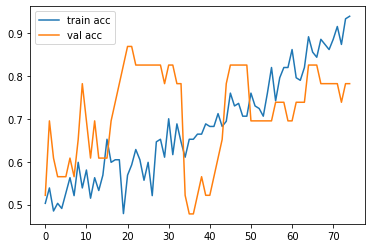

In [ ]:
import matplotlib.pyplot as plt

def plot_acc(ep, train_acc, val_acc, save = True):
  plt.plot(ep, train_acc, label = 'train acc')
  plt.plot(ep, val_acc, label = 'val acc')
  #plt.plot(ep, val_acc, label = 'val acc')
  plt.legend()
  if save:
    plt.savefig(saved_models_dir + "/accuracy.png")

plot_acc(ep, train_acc, val_acc)

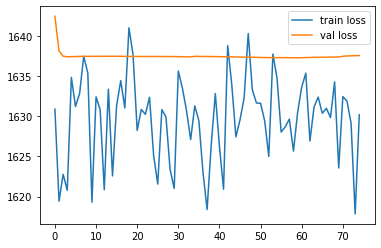

In [ ]:
def plot_loss(ep, t_loss, v_loss, save = True):
  plt.plot(ep, t_loss, label = 'train loss')
  plt.plot(ep, v_loss, label = 'val loss')
  #plt.plot(ep, val_acc, label = 'val acc')
  plt.legend()
  if save:
    plt.savefig(saved_models_dir + "/loss.png")

plot_loss(ep, train_losses, val_losses)